# Integrating Earth Observation with Open Buildings Data to Assess the Vulnerability of Human Settlement to Floods


### By

<img src='Emmanuel_Kipngetich.png' alt='Emmnuel Kpngetich'/>

## Introduction
### Background


Flooding destroys biodiversity, lives, livelihoods, infrastructure and other assets. It can also compound health hazards, such as cholera, as sewers overflow and fresh water mix with poluted water.

Water-Related Disaster Management (SDG 11.5) targets to  significantly reduce the number of deaths and the number of people affected and substantially decrease the direct economic losses relative to global gross domestic product caused by disasters, including water-related disasters, with a focus on protecting the poor and people in vulnerable situations.

This notebook, through analysing the flood prone-zone along River Nzoia-Budalangi Kenya, focuses on The United Nations Sustainable Developmentt Goal  (SDG) 6 CLEAN WATER AND SANITATION , and directly addresses Indicator 6.6.1 - Change in the extent of  water-related ecosystems 

### Area of Study

Budalangi Constituency is an electoral constituency in Kenya. It is one of seven constituencies in Busia County (others includes; Teso North, Teso South, Nambale, Matayos, Butula and Samia ) . The constituency was established for the 1997 elections.

The physical setting of Budalangi at the floodplain of the Nzoia river,the neighbouring Lake Victoria and increased runoff from degraded catchments are conttributory factors to the flooding in this area


The Nzoia River is a 257-kilometre-long  Kenyan river, rising from Cherangany hills. It passes through Kapsara, Springer ,Moi's bridge then crosses to Kakamega county.It flows south and then west, eventually flowing into Lake Victoria near the town of Port Victoria, in Budalangi Subcounty.The river has a discharge of about 118 m3/s or about 3,721 million cubic metres annually, making it the second biggest river in the country by discharge.


Like many rivers across the world, the Nzoia River in western Kenya pushes over its banks annually. Dykes usually contain the river, but in November 2008, the river burst through the dykes to flood the low-lying land around it. At least 5,000 people were marooned or evacuated from the banks of the swollen river, said the United Nations Office for the Coordination of Humanitarian Affairs on November 14(https://earthobservatory.nasa.gov/images/35977/flooding-on-the-nzoia-river)

### Platform and Discription of this Notebook

This Analysis was conducted in **Digital Earth Africa Analysis Sandbox**.

**Digital Earth Africa (DE Africa)** aims to improve the lives of Africans by providing planners and policy
makers with tailored Earth observation information to support better decision making and enhance
sustainable development outcomes.

DE Africa (Phase II, 2019 – 2022) aims to establish DE Africa as an African-based and managed
operational platform, funded by the Australian Government Department of Foreign Affairs and
Trade (DFAT), and The Leona M. and Harry B. Helmsley Charitable Trust (Helmsley).

The **DE Africa Sandbox** is a cloud-based computational platform, accessible to users for open source scientific notebook development, that operates through a Jupyter Lab environment.It provides users with access to data and analysis tools, democratising access to remote-sensing data to allow for ad-hoc report generation and rapid development of new algorithms

Within the DE Afric Sandbox,the following actitvities were perfomed;
* Loading satellite data over the area of study( Budalangi subcounty)
* Calculate Modified Normalized Difference Water Index (MNDWI)
* Resampling the time series of MNDWI to seasonal medians
* Calculating and plotting a time series of seasonal waterextent (in Square Kilometers
* Comparing the two nominated time-perionds and plotting where water-body extent has changed
* Extracting the flood zone from the detected water-body change region
* Importing an manipulation of  the Google's open building dataset
* reprojecting all the datasets to a common coordinate reference system for plotting and spatial     anallysis in the same geospatial dataframe
* Exporting the affected buingings to local PC storage 

***

## Data and Methodology

### Data 

* **Administrative Boundaries**

    The Kenya level 3 (Country, County and Subcounty ) admninistrative boundaries, source : IEBC,     Contributor:OCHA Regional Office for Southern and Eastern Africa (ROSEA) , updated : 28    September 2021 ,  were obtained from The Humanitarian Data Exchange platform https://data.humdata.org/dataset/cod-ab-ken
    
* **Satellite Data**

     Surface Reflectance Sentinel 2 Level 2 A are pre loaded together with other earth observation data in DE Africa enabling users to immediately start performing
     interactive analysis on the data without downloading  the raw data.
    
    
* **Building's Dataset**
    
    Open Buildings V1 Polygons  is  large-scale open dataset that  consists of outlines of buildings derived from high-resolution 50 cm satellite imagery. It contains 516M building detections across an area of 19.4M km2 (64% of the African continent)
   The building dataset of the area of study was  obtained through Google Earth Engine GEE and uploaded to DE Africa sandbox  https://code.earthengine.google.com/12209646ee7b17a7d36cb885bd2810d2
 
 
 
 ### Methodology
 
 

### **Load packages**
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube  
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import xr_animation, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.spatial import xr_vectorize
from datacube.utils import geometry

import json
from shapely.geometry import shape ,Point, Polygon

from odc.algo import xr_reproject



`%matplotlib inline` allows plotting of graphs and maps

The `datacube` allows creation of an object that can retrive data froom the datacube

The package `deafrica_tools` contains several modules that facilitates  loading, analyse and output data from Digital Earth Africa.



### **Connect to the datacube**

The Open Data Cube (ODC) is an Open Source Geospatial Data Management and Analysis Software project that helps harness the power of Satellite data.

In [2]:
dc = datacube.Datacube(app='Budalangi_Floods_Mapping')

`datacube.Datacube` class provides access to the datacube. 

`app` parameter is a unique name for the analysis which is based on the notebook file name

### **Set Up a Dask cluster**

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:40897' processes=1 threads=4, memory=28.14 GB>

### **Setting up Analysis Parameters**

In [4]:
products = ['s2_l2a']

time_range = ('2018', '2020')

min_gooddata = 0.0

measurements = ['green','swir_1', 'SCL']

resolution = (-20,20)

dask_chunks = {'time':1,'x':1250,'y':1250}

### **Region of Study**

* **Reading Kenya Subcounties Boundary data from file**

In [5]:
Kenya_Subcounties = gpd. read_file('ken_admbnda_adm0_iebc_20191031.geojson')

* **Ploting the Kenya Subcounsties and Exploring the attribute table**

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144     None       None   
1      0.917307    0.019957         Ainamoi   KE035190     None       None   
2      1.402637    0.038000           Aldai   KE029152     None       None   
3      1.081354    0.049357    Alego Usonga   KE041234     None       None   
4      0.743915    0.021365          Awendo   KE044254     None       None   
..          ...         ...             ...        ...      ...        ...   
285    1.010876    0.019180     Webuye West   KE039222     None       None   
286    0.630183    0.014610  West Mugirango   KE046271     None       None   
287    0.405298    0.005908       Westlands   KE047274     None       None   
288    1.214526    0.069243        Wundanyi   KE006024     None       None   
289    1.737731    0.086211           Yatta   KE016076     None       None   

    ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE        date  \
0         None   Uasin Gishu      KE027   Kenya         KE  2017-11-03   
1         None       Kericho      KE035   Kenya         KE  2017-11-03   
2         None         Nandi      KE029   Kenya         KE  2017-11-03   
3         None         Siaya      KE041   Kenya         KE  2017-11-03   
4         None        Migori      KE044   Kenya         KE  2017-11-03   
..         ...           ...        ...     ...        ...         ...   
285       None       Bungoma      KE039   Kenya         KE  2017-11-03   
286       None       Nyamira      KE046   Kenya         KE  2017-11-03   
287       None       Nairobi      KE047   Kenya         KE  2017-11-03   
288       None  Taita Taveta      KE006   Kenya         KE  2017-11-03   
289       None      Machakos      KE016   Kenya         KE  2017-11-03   

        validOn ValidTo                                           geometry  
0    2019-10-31    None  MULTIPOLYGON (((35.35933 0.52108, 35.36047 0.5...  
1    2019-10-31    None  MULTIPOLYGON (((35.26262 -0.23064, 35.26395 -0...  
2    2019-10-31    None  MULTIPOLYGON (((34.93989 0.08211, 34.94360 0.0...  
3    2019-10-31    None  MULTIPOLYGON (((34.20727 0.15971, 34.20937 0.1...  
4    2019-10-31    None  MULTIPOLYGON (((34.54577 -0.74820, 34.54787 -0...  
..          ...     ...                                                ...  
285  2019-10-31    None  MULTIPOLYGON (((34.67979 0.58459, 34.67877 0.5...  
286  2019-10-31    None  MULTIPOLYGON (((34.93189 -0.50115, 34.93215 -0...  
287  2019-10-31    None  MULTIPOLYGON (((36.79870 -1.19291, 36.80208 -1...  
288  2019-10-31    None  MULTIPOLYGON (((38.43298 -3.24366, 38.43235 -3...  
289  2019-10-31    None  MULTIPOLYGON (((37.51857 -1.05319, 37.51930 -1...  

[290 rows x 15 columns]

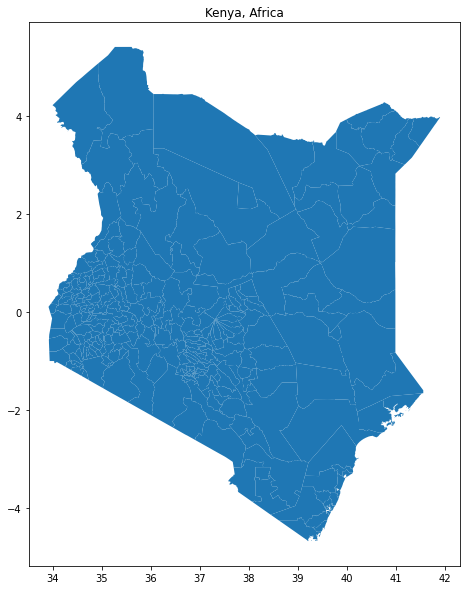

In [6]:
Kenya_Subcounties.plot( figsize = (10,10))
plt.title('Kenya, Africa')
Kenya_Subcounties

* **Extracting Budalangi Subcounty**

In [7]:
Budalangi_Subcounty = Kenya_Subcounties[Kenya_Subcounties.ADM2_EN == "Budalangi"]

* **Plotting Budalangi Subcounty and inspecting the crs**

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

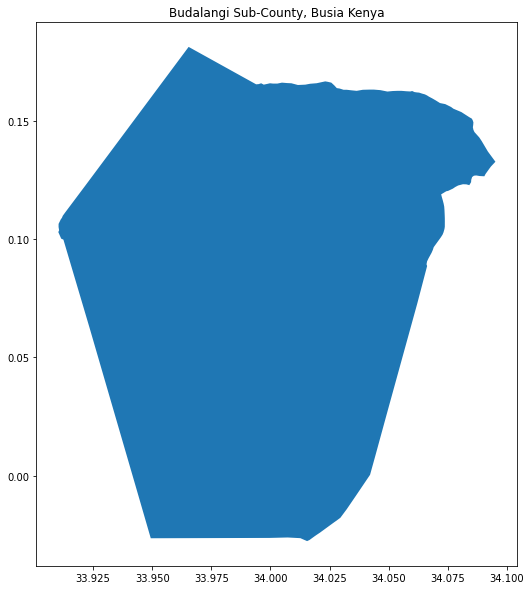

In [8]:
Budalangi_Subcounty.plot(figsize = (10,10))
plt.title('Budalangi Sub-County, Busia Kenya')
Budalangi_Subcounty.crs

* **projecting Budalangi subcounty crs from WGS 86( EPSG:4326) to WGS 84 UTM Zone 36 N( EPSG: 32636)**

In [9]:
Budalangi_Subcounty.to_crs(epsg=32636, inplace=True)


/env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


* **Creating a reuseable query for loading satellite data**

In [10]:
#create a geom object from the vector file
geom = geometry.Geometry(Budalangi_Subcounty.iloc[0].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{Budalangi_Subcounty.crs.to_epsg()}'))

water_query = {'time': time_range,
               'measurements': measurements,
               'resolution': resolution,
               'output_crs': 'EPSG:32636',
               'dask_chunks': dask_chunks,
               'geopolygon': geom,
               'group_by':'solar_day'
              }

* **Load Cloud-masked Sentinel 2 level 2 data**

In [11]:
filters=[('erosion', 5),("closing", 2),("opening", 2),("dilation", 1)]

ds = load_ard(dc=dc,
              products=products,
              min_gooddata=min_gooddata,
              mask_filters=filters,
              **water_query
                   )
print(ds)

/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('erosion', 5), ('closing', 2), ('opening', 2), ('dilation', 1)]
Applying pixel quality/cloud mask
Returning 218 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 218, y: 1156, x: 1030)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:07:58 ... 2020-12-27T08:...
  * y            (y) float64 2.003e+04 2.001e+04 ... -3.05e+03 -3.07e+03
  * x            (x) float64 6.013e+05 6.013e+05 ... 6.218e+05 6.219e+05
    spatial_ref  int32 32636
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1156, 1030), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1156, 1030), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 1156, 1030), meta=np.ndarray>
Attributes:
    crs:           EPSG:32636
    grid_mapping:  spatial_ref


* **Clipping the satellite data to Budalangi Subcounty**

In [12]:
#create mask
mask = xr_rasterize(Budalangi_Subcounty,ds)

#mask data
ds = ds.where(mask)

#remove SCL since we don't need it anymore
ds = ds.drop('SCL')

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

* **Calculate the MNDWI water index**

In [13]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index='MNDWI', collection='s2')

# drop green and swir since we don't need it
ds = ds.drop(['green','swir_1'])

* **Resample time series**

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the fmask layer) the data will be gappy and noisy. 
Resampling the data  to seasonal timestamps sing medians ensures consistent time-series.

In [14]:
sample_frequency="QS-DEC"  # quatrley starting in DEC, i.e. seasonal

#resample MNDWI using medians
print('calculating MNDWI medians')
mndwi = ds['MNDWI'].resample(time=sample_frequency).median().compute()


calculating MNDWI medians


* **Plotting  the MNDWI time-steps facets**

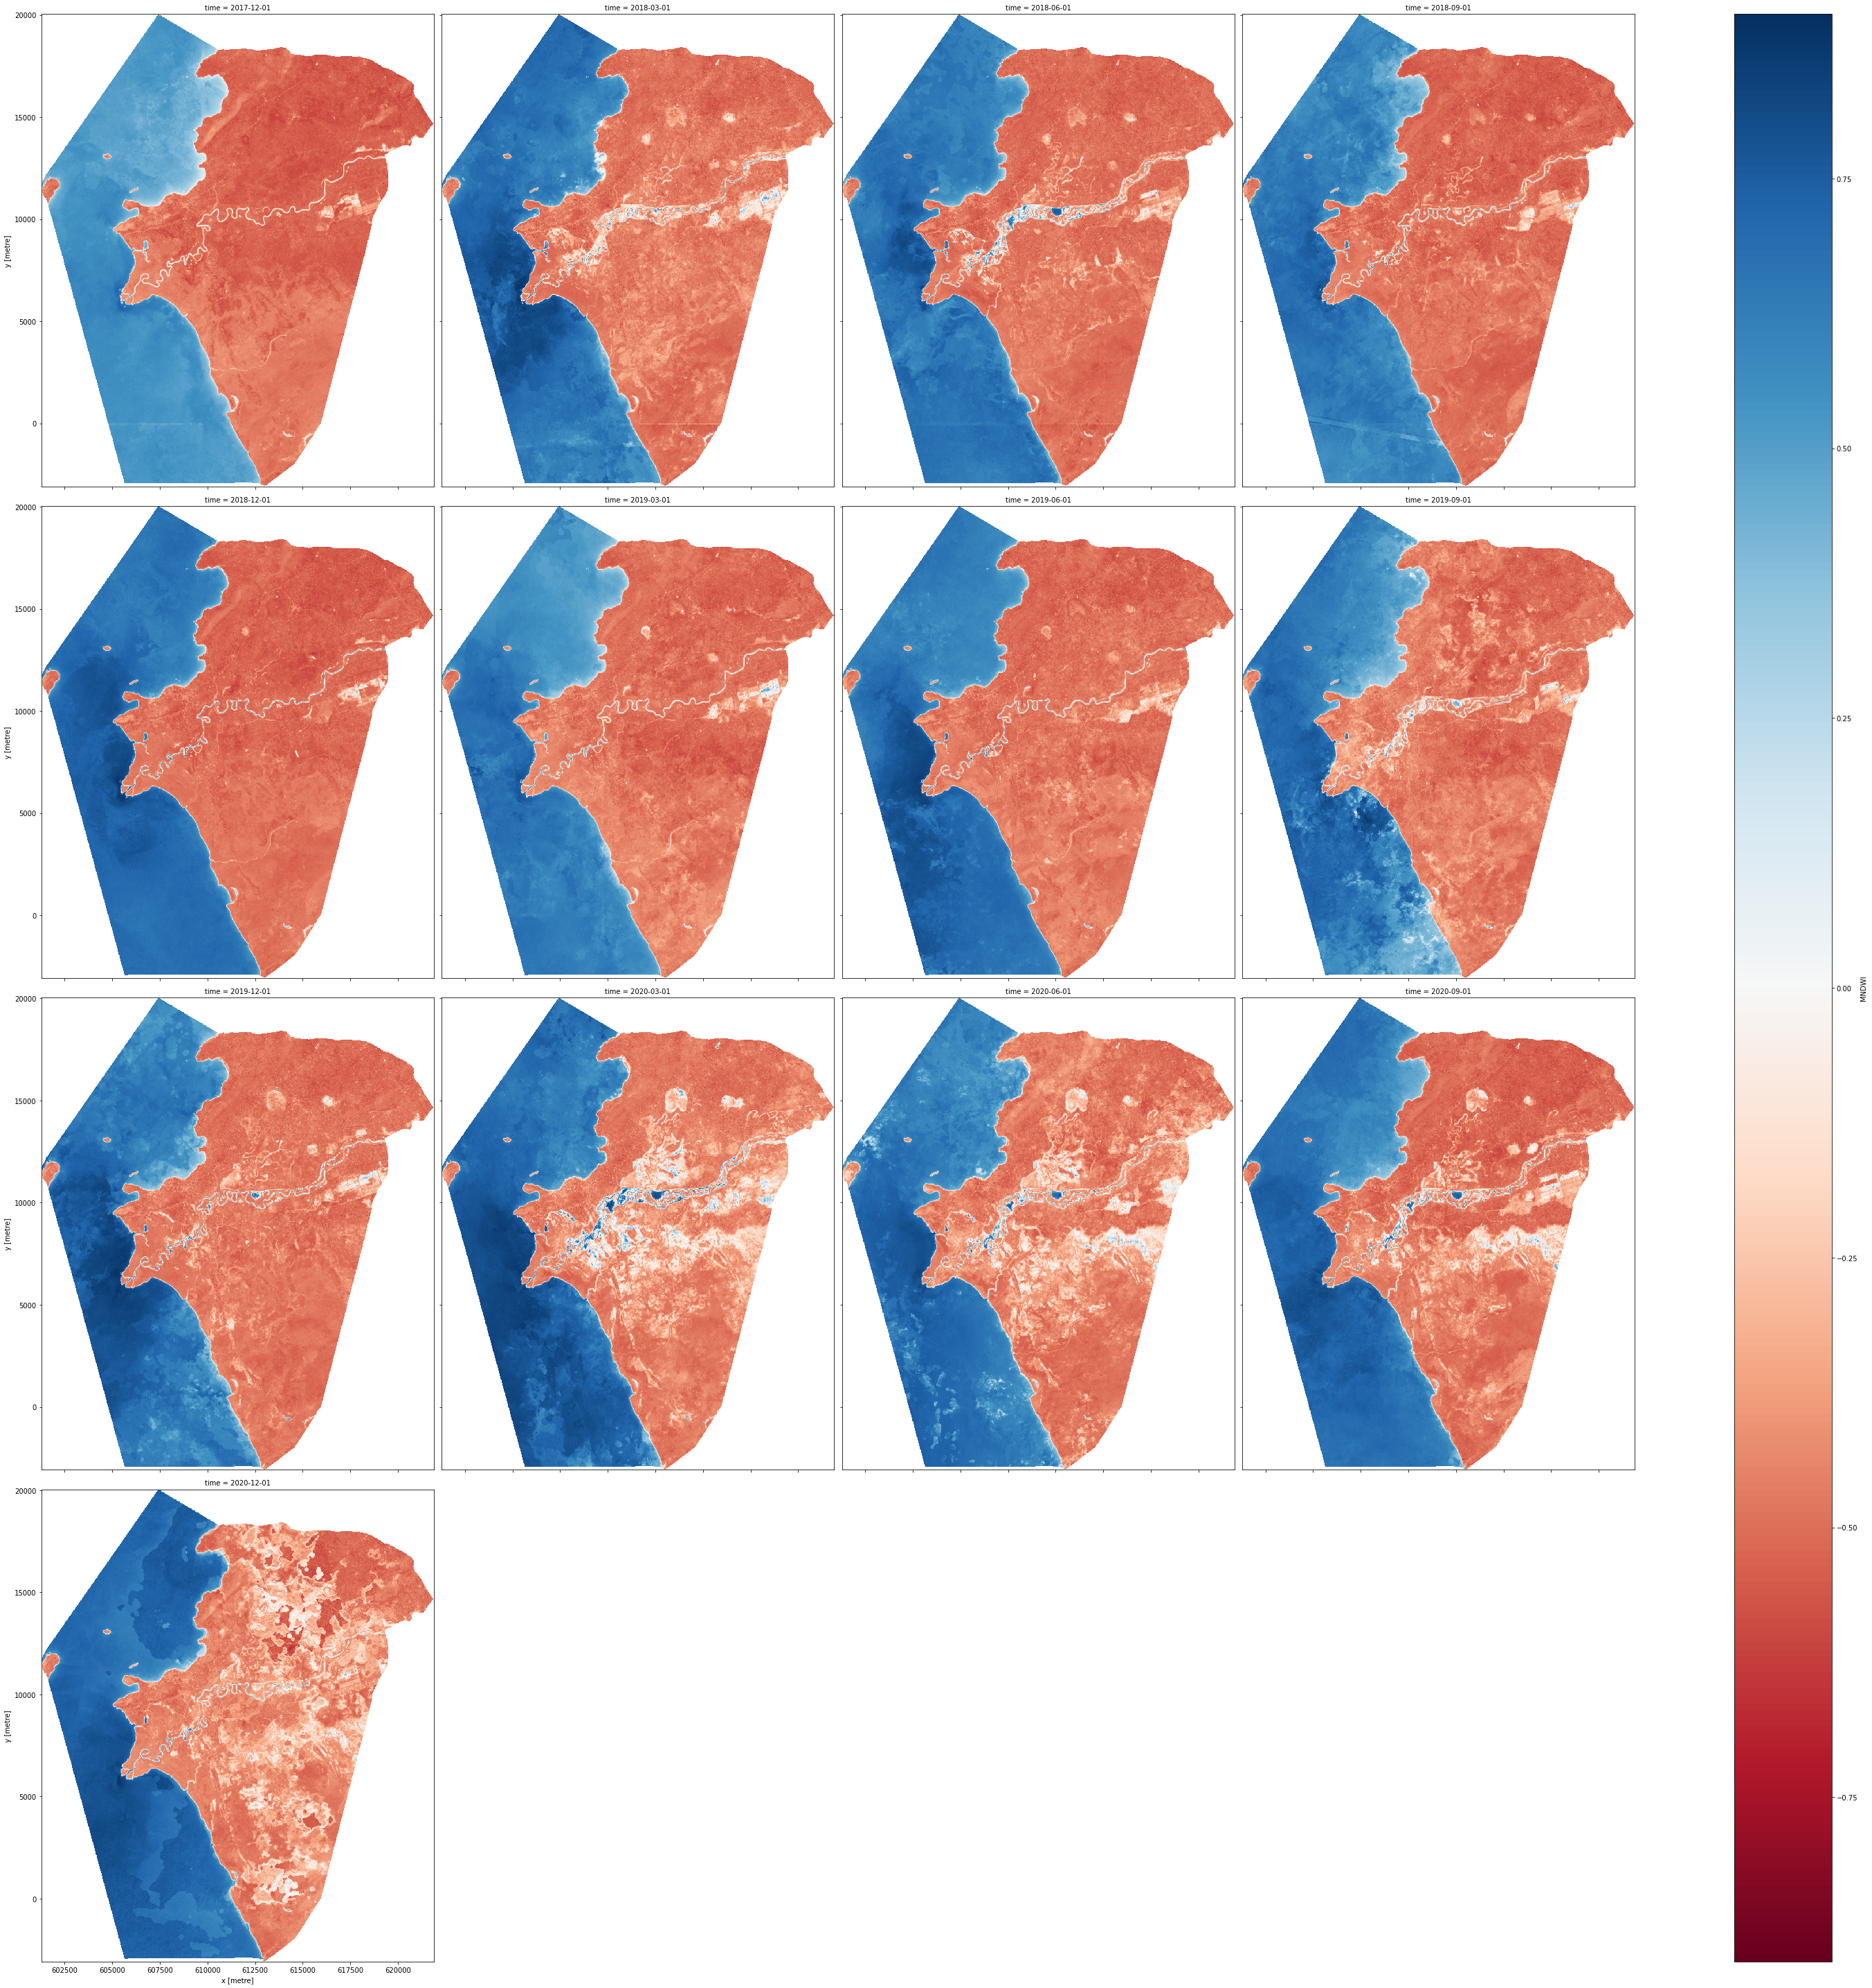

In [15]:
mndwi.plot(col='time', col_wrap=4, cmap='RdBu', size = 10);

* **Calculate the area per pixel**

In [16]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

* **Calculating the extent of water**

In [17]:
water = mndwi.where(mndwi > 0, np.nan)

area_ds = water.where(np.isnan(water),1)

ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

* **Plotting th seasonal water extent variation**

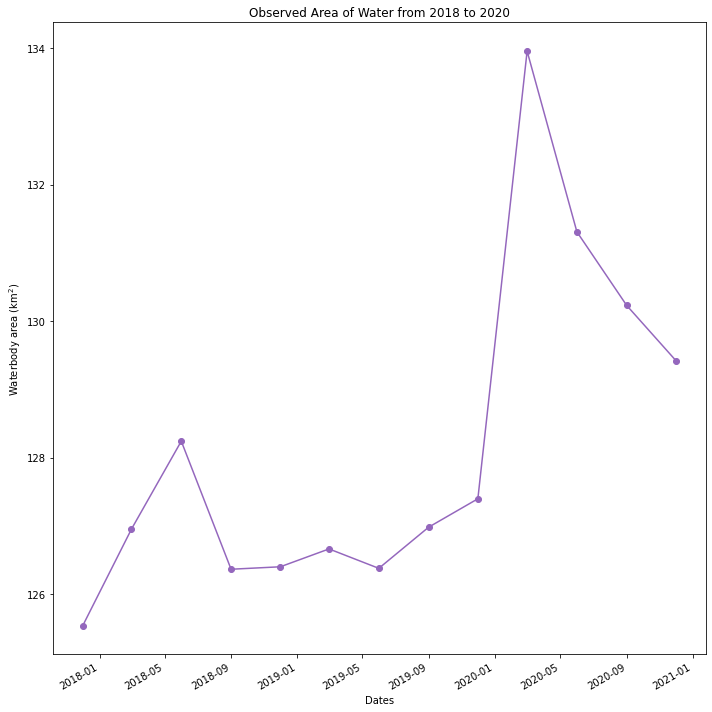

In [18]:
plt.figure(figsize=(10,10))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

* **Determinining minimum and maximum water extent**

<xarray.DataArray (time: 2)>
array(['2017-12-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


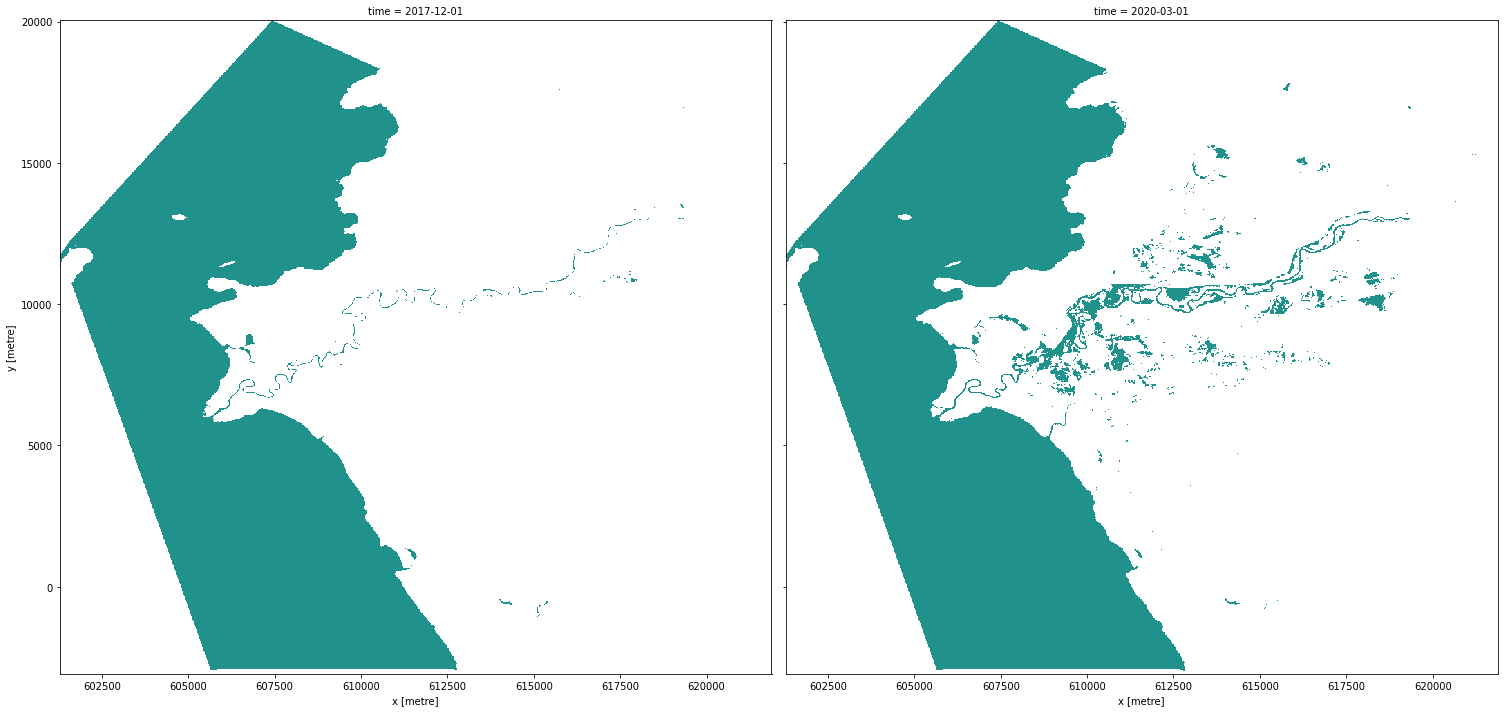

In [19]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)
area_ds.sel(time=time_xr).plot(  col="time", col_wrap=2, robust=True, size = 10, cmap='viridis', add_colorbar=False);

* **Comparing two perionds**

In [20]:
baseline_time = '2019-1-01'
analysis_time = '2018-6-06'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

* **Calculating the Change from the two nominated periods**

In [21]:
# calculating thhr ammount of water gain, loss and no change 


# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

#The dataset array is transform to 1 and 0 using the `astype(int)` function.
analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (analyse_total_value == 1))

#Permanent Land = 0
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

#Water loss = -1
water_disappeared = change.where(change == -1)

In [22]:
# calculating the area of water extent variations

total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
permanent_land_area = permanent_land.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

In [23]:
# Percentage Change in water extent
percentage_water_gain = round((water_apperaed_area /  total_area) * 100 , 2)
percentage_water_loss = round(water_disappeared_area /  total_area * 100 , 2)
percentage_permanent_water = round(permanent_water_area /  total_area * 100 , 2)
percentage_permanent_land = round(permanent_land_area /  total_area * 100, 2)

* **Plotting the Results**

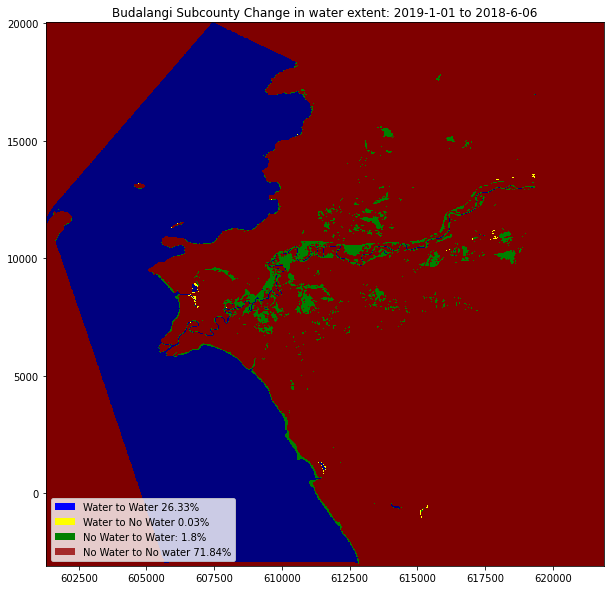

In [24]:
water_appeared_color = 'Green'
water_disappeared_color = 'Yellow'
stable_color = 'Blue'
land_color = 'Brown'

plot_aspect = image_aspect(area_ds)

ds_selected[1].plot.imshow(cmap='jet_r', add_colorbar=False, add_labels=False, figsize=(10,10))
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=stable_color), Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color),   Patch(facecolor=land_color)],
        [f'Water to Water {percentage_permanent_water}%', f'Water to No Water {percentage_water_loss}%' , f'No Water to Water: {percentage_water_gain}%',
         f'No Water to No water {percentage_permanent_land}%'],
         loc = 'lower left'
    );

plt.title('Budalangi Subcounty Change in water extent: '+baseline_time+' to '+analysis_time);

* **Plotting the flood zones**

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


   attribute                                           geometry
0        1.0  POLYGON ((610520.000 18320.000, 610560.000 183...
1        1.0  POLYGON ((610460.000 18240.000, 610460.000 182...
2        1.0  POLYGON ((610560.000 18220.000, 610600.000 182...
3        1.0  POLYGON ((610440.000 18160.000, 610460.000 181...
4        1.0  POLYGON ((610040.000 17980.000, 610040.000 179...


<AxesSubplot:>

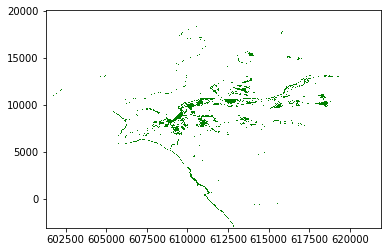

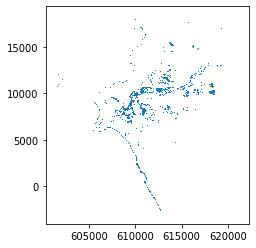

In [25]:
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)

flood_zone = xr_vectorize(water_appeared,
                   crs='epsg:32636',
                   
                   mask=water_appeared.values==1)

print(flood_zone.head())
flood_zone.plot( )

* **Vectorizing  the flood zone raster**

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


   attribute                                           geometry
0        1.0  POLYGON ((610520.000 18320.000, 610560.000 183...
1        1.0  POLYGON ((610460.000 18240.000, 610460.000 182...
2        1.0  POLYGON ((610560.000 18220.000, 610600.000 182...
3        1.0  POLYGON ((610440.000 18160.000, 610460.000 181...
4        1.0  POLYGON ((610040.000 17980.000, 610040.000 179...


<AxesSubplot:>

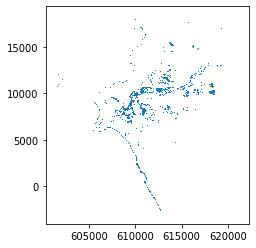

In [26]:

flood_zone = xr_vectorize(water_appeared,
                   crs='epsg:32636',
                   
                   mask=water_appeared.values==1)

print(flood_zone.head())
flood_zone.plot( )


* **Adding area column (in km) to flood_zone shapefile**

In [27]:
flood_zone["area"] =  flood_zone['geometry'].area/ 10**6

In [28]:
flood_zone

attribute                                           geometry    area
0           1.0  POLYGON ((610520.000 18320.000, 610560.000 183...  0.0052
1           1.0  POLYGON ((610460.000 18240.000, 610460.000 182...  0.0008
2           1.0  POLYGON ((610560.000 18220.000, 610600.000 182...  0.0040
3           1.0  POLYGON ((610440.000 18160.000, 610460.000 181...  0.0016
4           1.0  POLYGON ((610040.000 17980.000, 610040.000 179...  0.0004
...         ...                                                ...     ...
1541        1.0  POLYGON ((615180.000 -620.000, 615180.000 -640...  0.0008
1542        1.0  POLYGON ((615160.000 -640.000, 615160.000 -660...  0.0004
1543        1.0  POLYGON ((615140.000 -720.000, 615180.000 -720...  0.0028
1544        1.0  POLYGON ((611240.000 600.000, 611340.000 600.0...  0.1864
1545        1.0  POLYGON ((612180.000 -1580.000, 612200.000 -15...  0.0676

[1546 rows x 3 columns]

* **Importing the Buildings dataset from file and inspecting the crs**

In [29]:
builtUp = gpd.read_file('Budalangi_buildings.geojson')
builtUp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

* **Projecting the building's crs and plotting**

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

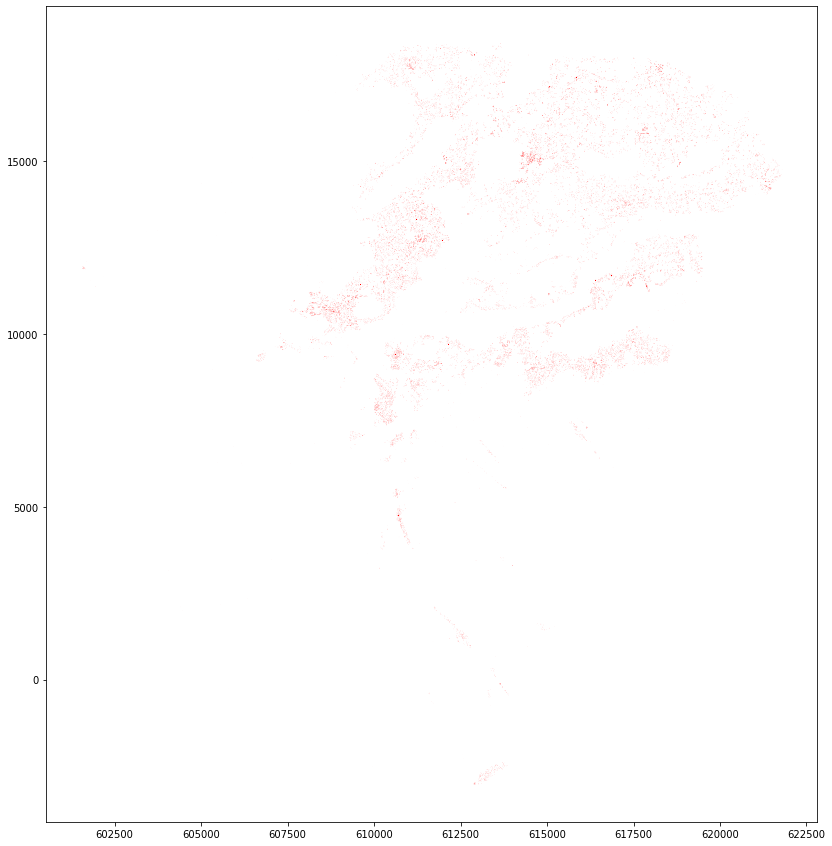

In [30]:
builtUp.to_crs(epsg=32636, inplace=True)
builtUp.plot(color= 'red',alpha=1, figsize=(15,15))
builtUp.crs

* **Plotting all datasets in same axes**

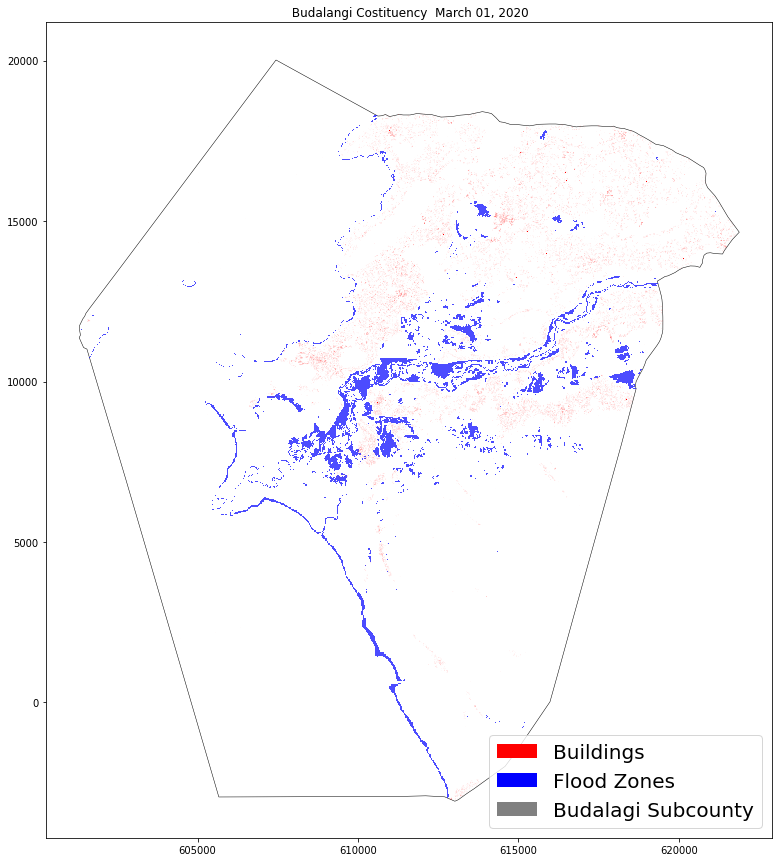

In [31]:


fig , ax1 = plt.subplots(figsize=(15,15))
Budalangi_Subcounty.plot(ax =ax1,color='white', edgecolor='black' ,linewidth=0.5 )
flood_zone.plot(ax =ax1,color='blue',alpha=0.7,)
builtUp.plot( ax=ax1, color= 'red',alpha=1)




plt.title(' Budalangi Costituency  March 01, 2020')
plt.legend(
        [Patch(facecolor='Red'), Patch(facecolor= 'Blue'), Patch(facecolor = 'Gray')],
        [f'Buildings', f'Flood Zones' , f'Budalagi Subcounty'
         ],
         loc = 'lower right', prop={"size":20}
    );

* **Determinuing the affected builtup areas**

To identify buildins that were subject to submerging, clipping is done with building dataset as input and flood zone as the mask

(608000.0, 612000.0)

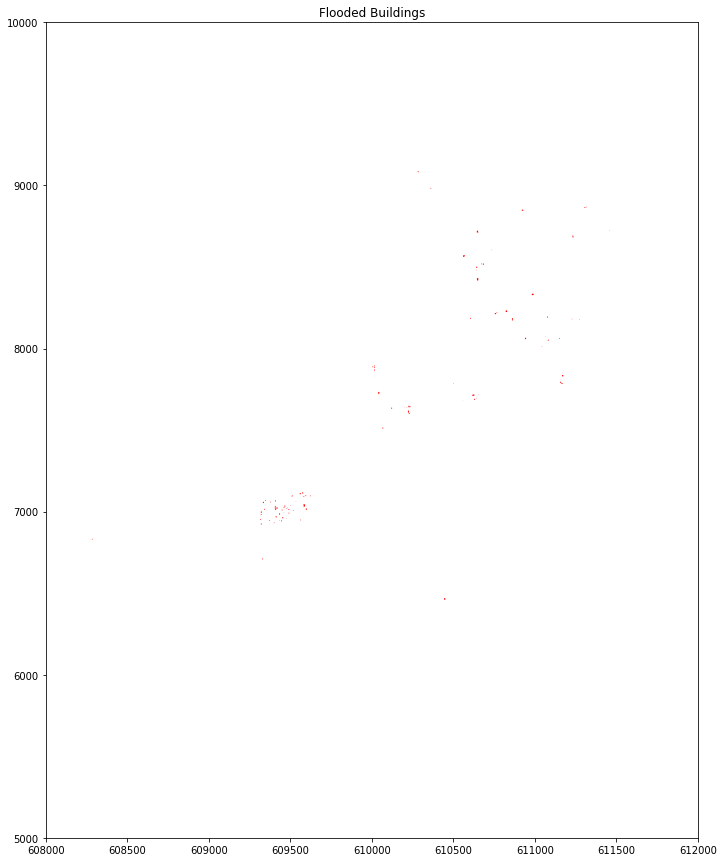

In [32]:
affected_builtup = gpd.clip(builtUp, flood_zone)


affected_builtup.plot( color= 'red',alpha=1, figsize=(15,15))
plt.title('Flooded Buildings')
plt.ylim((5000, 10000))
plt.xlim((608000, 612000))

* **Exporting the outputs to file for interactive visualization**

In [33]:
flood_zone.to_file("flood_zone_area.shp")

builtUp.to_file("All_buildings.shp")

affected_builtup.to_file("flooded.shp")


/tmp/ipykernel_384/1731508834.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  builtUp.to_file("All_buildings.shp")
/tmp/ipykernel_384/1731508834.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  affected_builtup.to_file("flooded.shp")
